In [1]:
import geopandas as gpd
import pandas as pd

from sklearn.model_selection import train_test_split, RepeatedKFold

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns

In [2]:
from custom.utils import import_shrug_shapefiles, import_shrug_r_keys, get_bounds, create_coords_list, show_results

## Connect shapes to SHRUG

In [3]:
shrug_shp = import_shrug_shapefiles()
shrug_r_keys = import_shrug_r_keys()

### Match shapes to shrids

In [4]:
shrug_r_matched = pd.merge(shrug_shp, shrug_r_keys, on=["pc11_state_id", "pc11_district_id", "pc11_subdistrict_id", "pc11_village_id"], how="inner")
shrug_r_matched

,pc11_state_id,pc11_district_id,pc11_subdistrict_id,pc11_village_id,tv_name,geometry,shrid
0,1,1,1,1,Bore,"POLYGON ((73.98476 34.65844, 73.98430 34.65840...",11-01-000001
1,1,1,1,2,Keran,"POLYGON ((73.96017 34.64970, 73.96121 34.65066...",11-01-000002
2,1,1,1,3,Bugna,"POLYGON ((73.95191 34.60770, 73.95261 34.60854...",11-01-000003
3,1,1,1,4,Bichwal,"POLYGON ((73.97331 34.57392, 73.97265 34.57381...",11-01-000004
4,1,1,1,5,Mindiyan,"POLYGON ((74.05823 34.65639, 74.05905 34.65657...",11-01-000005
...,...,...,...,...,...,...,...
634846,35,640,5924,645566,Butler Bay Forest Camp 4-III (FDCA),"POLYGON ((92.55169 10.63969, 92.55072 10.63605...",11-35-645566
634847,35,640,5924,645567,Butler Bay Forest Camp 4-IV (FDCA),"POLYGON ((92.52477 10.63171, 92.52570 10.63001...",11-35-645567
634848,35,640,5924,645568,Red Oil Palm (Nursery Camp),"POLYGON ((92.54288 10.61653, 92.54295 10.61557...",11-35-645568
634849,35,640,5924,645569,Butler Bay Forest Camp 4-II (FDCA),"POLYGON ((92.53848 10.58244, 92.53712 10.58105...",11-35-645569


In [5]:
# restrict to 6 focus states
shrid_geom_df = shrug_r_matched[shrug_r_matched["pc11_state_id"].isin([8, 16, 18, 20, 22, 23, 28])]

## Create list of coords to fetch from MOSAIKS

In [6]:
min_long, min_lat, max_long, max_lat = get_bounds(shrid_geom_df).values()
coords_list = create_coords_list(min_long, min_lat, max_long, max_lat, step=0.05)
points = gpd.points_from_xy(x=coords_list[:, 1], y=coords_list[:, 0])
coords_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
print("Number of coord pairs in grid:", coords_gdf.shape[0])

Number of coord pairs in grid: 186912


In [7]:
# Filter coords list to only include points that land within the areas of the shapefile
selected_coords_gdf = coords_gdf.sjoin(shrid_geom_df, how="inner")
selected_coords_gdf = selected_coords_gdf.drop("index_right", axis=1).sort_values(by=["shrid"])
print("Number of coord pairs selected:", coords_gdf.shape[0])

Number of coord pairs selected: 186912


<AxesSubplot: >

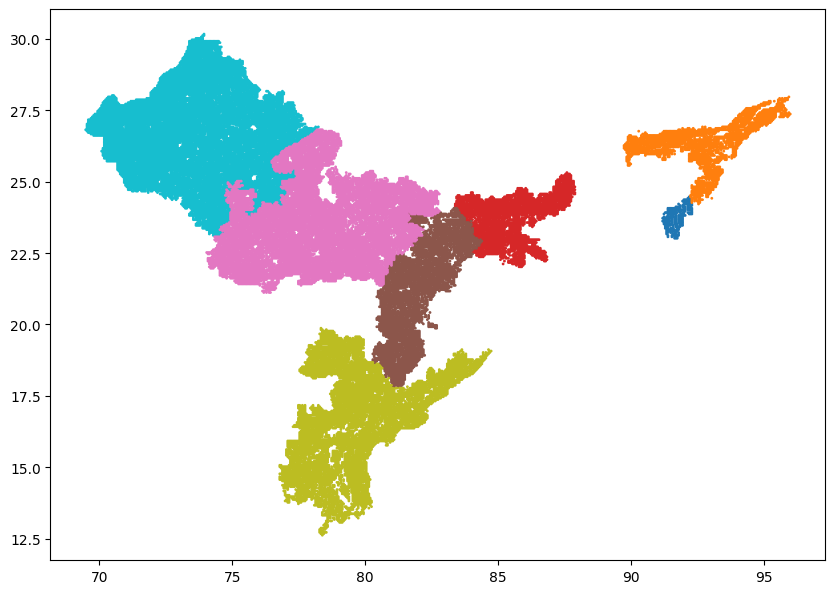

In [8]:
selected_coords_gdf.plot(column=selected_coords_gdf["pc11_state_id"].astype(str), figsize=(10, 10), markersize=1)

### Export list of coordinates...

...to download MOSAIKS features for through File Query

In [9]:
selected_coords = pd.DataFrame({"Latitude":selected_coords_gdf.geometry.y, "Longitude":selected_coords_gdf.geometry.x})
selected_coords.to_csv("../data/MOSAIKS/ALL_NEW_coords_request.csv", index=False)

## Load MOSAIKS (features)

Load resulting MOSAIKS features download...

In [10]:
mosaiks_features = pd.read_csv("../data/MOSAIKS/ALL_Mosaiks_features.csv")
mosaiks_features

,Lat,Lon,,.1,.2,.3,.4,.5,.6,.7,...,.3990,.3991,.3992,.3993,.3994,.3995,.3996,.3997,.3998,.3999
0,22.975,83.645,0.126109,0.279317,0.119949,0.059453,0.187922,0.381253,0.351912,0.521019,...,0.055999,0.036112,0.277964,0.149706,0.032252,0.298511,0.985324,0.415393,0.076452,0.087803
1,24.225,83.895,0.354638,0.619183,0.314939,0.126575,0.489874,0.942453,0.503790,0.957585,...,0.608487,0.521773,1.386157,0.886475,0.457900,1.199394,3.349206,0.968169,0.583446,0.431638
2,23.675,85.095,0.033638,0.062720,0.064060,0.001588,0.042855,0.143067,0.224970,0.612251,...,0.016302,0.024366,0.226082,0.081809,0.009231,0.085985,0.645035,0.133651,0.012422,0.056483
3,27.175,72.795,0.291744,0.568002,0.097871,0.412627,0.402672,0.474590,0.126199,0.146495,...,0.161278,0.071840,0.248706,0.203490,0.121913,0.597880,1.151498,0.288054,0.289036,0.034432
4,27.225,72.795,0.298046,0.490456,0.120191,0.386469,0.406060,0.322313,0.099036,0.119901,...,0.135374,0.045236,0.208039,0.151310,0.084836,0.573566,1.025858,0.190355,0.278283,0.015242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37365,16.625,80.695,0.076223,0.233542,0.046216,0.115498,0.138076,0.207082,0.177275,0.314915,...,0.066637,0.022165,0.202075,0.094978,0.038883,0.324979,0.832501,0.352220,0.138609,0.033668
37366,16.475,80.735,0.072734,0.141272,0.079598,0.019393,0.104031,0.222947,0.168088,0.501920,...,0.110914,0.129260,0.445486,0.215557,0.092875,0.238071,1.042060,0.184675,0.113125,0.111794
37367,17.475,80.735,0.021570,0.023697,0.090509,0.005240,0.019797,0.055862,0.146219,0.758257,...,0.007868,0.022282,0.229796,0.040333,0.002768,0.032617,0.599451,0.035568,0.006926,0.021628
37368,17.525,80.735,0.059092,0.118397,0.110982,0.022088,0.083395,0.213573,0.257138,0.830387,...,0.044829,0.068337,0.420833,0.151237,0.030061,0.176527,1.014546,0.228843,0.049239,0.099832


In [11]:
# Make into a GeoDataFrame
mosaiks_coords_points = gpd.points_from_xy(x=mosaiks_features["Lon"], y=mosaiks_features["Lat"])
mosaiks_features_gdf = gpd.GeoDataFrame(mosaiks_features, geometry=mosaiks_coords_points, crs="EPSG:4326")

## Match `shrid` shapes to MOSAIKS features

In [12]:
# add shrid column to mosaiks features, based on whether the the MOSAIKS coordinate is within the shrid area
shrid_geom_df['saved_shrid_geoms'] = shrid_geom_df['geometry'].copy()
mosaiks_features_df = mosaiks_features_gdf.sjoin(shrid_geom_df).drop(columns=["index_right"])
mosaiks_features_df.head()

/opt/miniconda3/envs/nudge_up/lib/python3.9/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Lat,Lon,,.1,.2,.3,.4,.5,.6,.7,...,.3998,.3999,geometry,pc11_state_id,pc11_district_id,pc11_subdistrict_id,pc11_village_id,tv_name,shrid,saved_shrid_geoms
1,24.225,83.895,0.354638,0.619183,0.314939,0.126575,0.489874,0.942453,0.503790,0.957585,...,0.583446,0.431638,POINT (83.89500 24.22500),20,358,2624,365754,Ketat Khurd,11-20-365754,"POLYGON ((83.89729 24.21819, 83.89646 24.21856..."
3,27.175,72.795,0.291744,0.568002,0.097871,0.412627,0.402672,0.474590,0.126199,0.146495,...,0.289036,0.034432,POINT (72.79500 27.17500),8,113,567,84155,Bheeyasar,11-08-084154,"POLYGON ((72.80183 27.19340, 72.80154 27.19058..."
4,27.225,72.795,0.298046,0.490456,0.120191,0.386469,0.406060,0.322313,0.099036,0.119901,...,0.278283,0.015242,POINT (72.79500 27.22500),8,113,567,84154,Banswara Nagar,11-08-084154,"POLYGON ((72.81340 27.23518, 72.80976 27.23294..."
5,27.275,72.795,0.287745,0.584380,0.071600,0.593021,0.431653,0.350509,0.104469,0.067983,...,0.242943,0.004787,POINT (72.79500 27.27500),8,113,567,84153,Sai Nagar,11-08-084154,"POLYGON ((72.79986 27.27872, 72.80004 27.27818..."
6,27.325,72.795,0.337010,0.637845,0.082260,0.734296,0.495953,0.329871,0.078316,0.053293,...,0.294352,0.003755,POINT (72.79500 27.32500),8,113,567,84150,Khariya Kansingh,11-08-084150,"POLYGON ((72.80608 27.32345, 72.80596 27.32334..."


## Import SHRUG SECC (target)

In [13]:
shrug_secc = pd.read_csv("../data/SHRUG/shrug-v1.5.samosa-secc-csv/shrug_secc.csv")
shrug_secc.head()

,shrid,secc_inc_cultiv_share,nco2d_cultiv_share,secc_cons_pc_rural,secc_cons_pc_urban,secc_pov_rate_rural,secc_pov_rate_urban,secc_pov_rate_tend_rural,secc_pov_rate_tend_urban,num_members_mean_rural,num_members_mean_urban
0,11-01-000002,0.013158,0.248276,13509.520,NaN,0.477891,NaN,0.391156,NaN,6.241497,NaN
1,11-01-000005,0.023762,0.518018,8611.758,NaN,0.776421,NaN,0.679805,NaN,7.101151,NaN
2,11-01-000006,0.149701,0.400000,9498.939,NaN,0.730325,NaN,0.624344,NaN,6.672613,NaN
3,11-01-000007,0.005882,0.803150,11964.710,NaN,0.530650,NaN,0.386093,NaN,6.968893,NaN
4,11-01-000009,0.079812,0.291469,10137.010,NaN,0.681202,NaN,0.661167,NaN,5.824985,NaN


In [14]:
shrug_secc.shape

(565991, 11)

In [15]:
y_name = "secc_pov_rate_rural"
shrug_y = shrug_secc[["shrid", y_name]].copy()
# drop entries with y
shrug_y.dropna(inplace=True)
shrug_y

,shrid,secc_pov_rate_rural
0,11-01-000002,0.477891
1,11-01-000005,0.776421
2,11-01-000006,0.730325
3,11-01-000007,0.530650
4,11-01-000009,0.681202
...,...,...
565985,11-35-645566,0.231884
565986,11-35-645567,0.293532
565987,11-35-645568,0.082759
565988,11-35-645569,0.127168


## Match target to features

In [16]:
# add MOSAIKS features to the SECC data
df = pd.merge(shrug_y, mosaiks_features_df, on="shrid")
df.head()

,shrid,secc_pov_rate_rural,Lat,Lon,,.1,.2,.3,.4,.5,...,.3997,.3998,.3999,geometry,pc11_state_id,pc11_district_id,pc11_subdistrict_id,pc11_village_id,tv_name,saved_shrid_geoms
0,11-08-064109,0.378517,29.975,73.545,0.196009,0.680680,0.029068,0.879884,0.377896,0.362932,...,0.396899,0.569372,0.030148,POINT (73.54500 29.97500),8,99,457,64109,8 S,"POLYGON ((73.54595 29.97968, 73.54675 29.97921..."
1,11-08-064117,0.191759,29.925,73.445,0.179314,0.624693,0.068403,0.533572,0.334091,0.558697,...,0.535226,0.483613,0.077517,POINT (73.44500 29.92500),8,99,457,64117,16 S,"POLYGON ((73.44757 29.92049, 73.44744 29.92047..."
2,11-08-064122,0.191011,29.925,73.485,0.210474,0.575617,0.105338,0.349345,0.346368,0.618880,...,0.582594,0.467674,0.085019,POINT (73.48500 29.92500),8,99,457,64122,4 X,"POLYGON ((73.48588 29.93462, 73.48593 29.93427..."
3,11-08-064130,0.558712,29.925,73.545,0.148078,0.452229,0.072211,0.255199,0.254243,0.547036,...,0.529162,0.299242,0.085201,POINT (73.54500 29.92500),8,99,457,64130,21 H,"POLYGON ((73.55564 29.93518, 73.55552 29.93491..."
4,11-08-064139,0.276619,29.975,73.595,0.173757,0.581114,0.052733,0.498324,0.316495,0.488720,...,0.476170,0.379888,0.050585,POINT (73.59500 29.97500),8,99,457,64139,13 H,"POLYGON ((73.61167 29.98067, 73.61163 29.98057..."


### Select X and y

In [17]:
geo_cols = [
    "shrid",
    "Lat",
    "Lon",
    "geometry",
    "pc11_state_id",
    "pc11_district_id",
    "pc11_subdistrict_id",
    "pc11_village_id",
    "tv_name",
    "saved_shrid_geoms",
]

In [18]:
X = df.drop(geo_cols + [y_name], axis=1)

In [19]:
y = df[y_name]

## Model A
Datapoints = latlong points

### Train

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1,)

In [21]:
# define model evaluation method
cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
# define model
model = RidgeCV(alphas=[1, 10], cv=cv) # alphas here refer to lambda values to try #0.001, 0.01, 

# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 1.000000


In [26]:
# # or
# model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, n_jobs=-1)
# # fit model
# model.fit(X_train, y_train)

### Make predictions and evaluate performance

Next, we use the trained model to make predictions in the test set.

In [29]:
#predict model
y_pred = model.predict(X_test)

r2: 0.300666
pearson: 0.548478
kendall: 0.394145
spearman: 0.558030


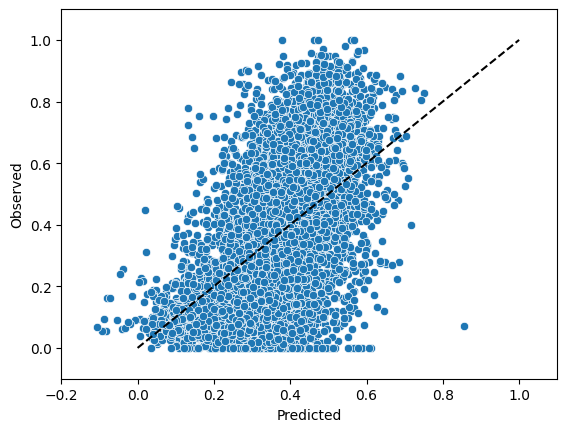

In [30]:
show_results(y_test, y_pred)

### Spatial visualization

In [44]:
# get geometries by subsetting original df to only test datapoints
y_gdf = df.loc[list(y_test.index), geo_cols]
# add true and predicted values
y_gdf['observed'] = y_test
y_gdf['predicted'] = y_pred
# y_gdf.head()

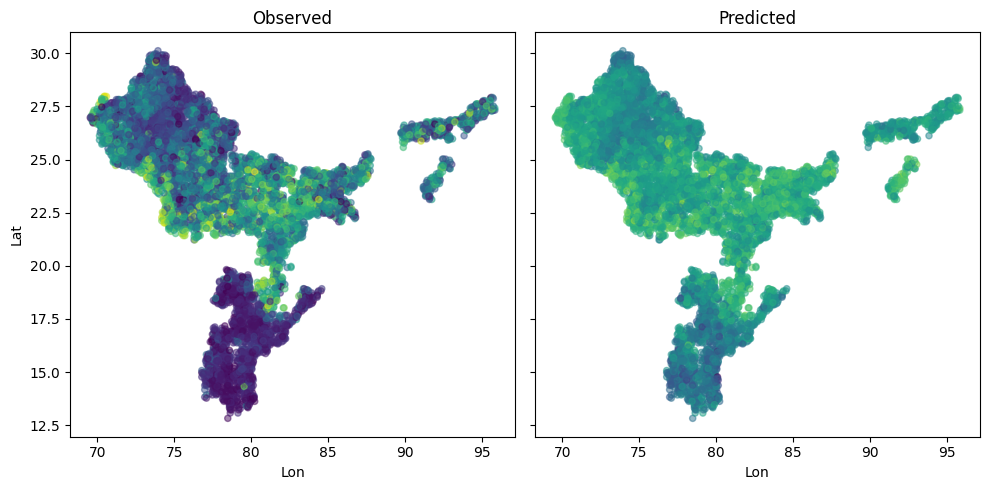

In [33]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

vmax = max(y_test.max(), y_pred.max())
vmin = min(y_test.min(), y_pred.min())

# plot observed
y_gdf.plot(
    kind="scatter",
    x="Lon",
    y="Lat",
    c="observed",
    colorbar=False,
    alpha=0.5,
    # vmin=vmin,
    # vmax=vmax,
    ax=axes[0],
)
axes[0].set_title("Observed")

# plot predicted
y_gdf.plot(
    kind="scatter",
    x="Lon",
    y="Lat",
    c="predicted",
    colorbar=False,
    alpha=0.5,
    # vmin=vmin,
    # vmax=vmax,
    ax=axes[1],
)
axes[1].set_title("Predicted")

plt.tight_layout()

### Evaluate predictions at the aggregated levels

In [40]:
print("Total test datapoints: ", y_gdf.shape[0])

Total test datapoints:  6780


#### shrid

Datapoints with unique shrids:  6555
r2: 0.303458
pearson: 0.551016
kendall: 0.396416
spearman: 0.561253


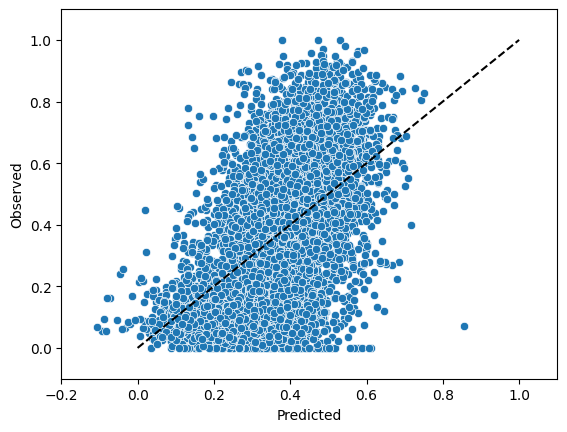

In [41]:
shrid_ys = y_gdf.groupby(["shrid"])[["observed", "predicted"]].mean()
print("Datapoints with unique shrids: ", shrid_ys.shape[0])

show_results(shrid_ys["observed"], shrid_ys["predicted"])

#### village

Datapoints with unique villages:  6578
r2: 0.302777
pearson: 0.550387
kendall: 0.395976
spearman: 0.560638


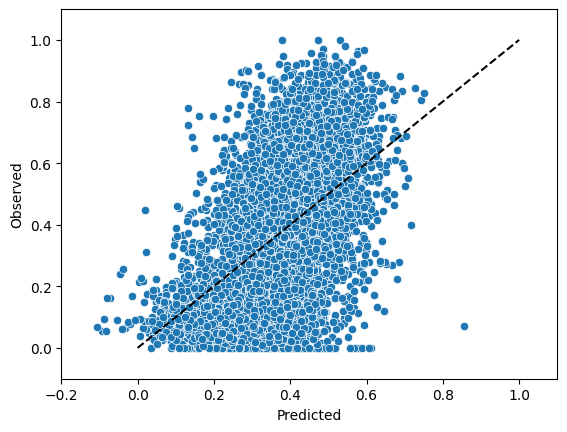

In [42]:
village_ys = y_gdf.groupby(
    [
        "pc11_state_id",
        "pc11_district_id",
        "pc11_subdistrict_id",
        "pc11_village_id",
    ],
    as_index=False,
)[["observed", "predicted"]].mean()
print("Datapoints with unique villages: ", village_ys.shape[0])

show_results(village_ys["observed"], village_ys["predicted"])

#### subdistrict

Datapoints with unique subdistricts:  1802
r2: 0.428689
pearson: 0.679124
kendall: 0.503750
spearman: 0.702818


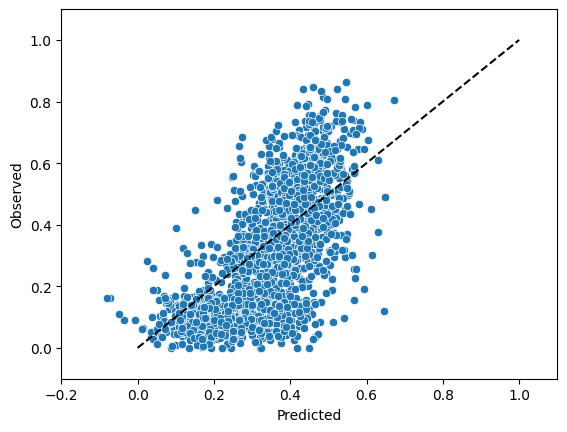

In [43]:
subdistrict_ys = y_gdf.groupby(
    [
        "pc11_state_id",
        "pc11_district_id",
        "pc11_subdistrict_id"
    ],
    as_index=False,
)[["observed", "predicted"]].mean()
print("Datapoints with unique subdistricts: ", subdistrict_ys.shape[0])

show_results(subdistrict_ys["observed"], subdistrict_ys["predicted"])